# MLP in PyTorch
- What is an MLP?
    - a fully connected neural network
    - sequence of layers connected in tandem

In [38]:
# imports
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim

import tqdm

import matplotlib.pyplot as plt

## Basic Steps
1. Load Data
2. Define PyTorch Model
3. Define Loss Functiona and Optimizers
4. Run a Training Loop
5. Evaluate the Model
6. Make Predictions

## 1 Load Data
- Pima Indians onset of diabetes dataset: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
- Binary classification: onset of diabetes as 1 or not as 0

- Input Variables (X)
    -  Number of times pregnant
    - Plasma glucose concentration at 2 hours in an oral glucose tolerance test
    - Diastolic blood pressure (mm Hg)
    - Triceps skin fold thickness (mm)
    - 2-hour serum insulin (μIU/ml)
    - Body mass index (weight in kg/(height in m)2)
    - Diabetes pedigree function
    - Age (years) 
- Outputs Variable (y)
    - Class label (0 or 1)

- Data should be split into train and test set
    - **train set**: used to train the model
    - **test set**: used to benchmark the model on unseen data

In [23]:
# load data
dataset = np.loadtxt('data/pima-indians-diabetes.csv', delimiter=',')
# frist 8 columns are the features
# the 9th column is the label
print("Numpy arrays:")
print("shape dataset:", dataset.shape)
X = dataset[:, :8]
y = dataset[:, -1]

print("shape X:", X.shape, "tpye:", X.dtype)
print("shape y:", y.shape, "tpye:", y.dtype)
print("y before reshape:", y[:10])
print("-"*20)

# data needs to be converted to PyTorch tensors
# numpy is 64-bit floating point but PyTorch operates on
# 32-bit floating point
# reshape y to make every label its own tensor
# PyTorch prefers  n x 1 matrix over n-vectors
print("PyTorch Tensor:")
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1,1)
print("shape X:", X.shape, "tpye:", X.dtype)
print("shape y:", y.shape, "tpye:", y.dtype)
print("y after reshape:", y[:10])
print("-"*20)

# Split data into training and test sets
Xtrain = X[:700]
ytrain = y[:700]
Xtest = X[700:]
ytest = y[700:]
print("shape of train set:", Xtrain.shape, ytrain.shape)
print("shape of test set:", Xtest.shape, ytest.shape)

Numpy arrays:
shape dataset: (768, 9)
shape X: (768, 8) tpye: float64
shape y: (768,) tpye: float64
y before reshape: [1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
--------------------
PyTorch Tensor:
shape X: torch.Size([768, 8]) tpye: torch.float32
shape y: torch.Size([768, 1]) tpye: torch.float32
y after reshape: tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]])
--------------------
shape of train set: torch.Size([700, 8]) torch.Size([700, 1])
shape of test set: torch.Size([68, 8]) torch.Size([68, 1])


## 2 Define Model
- How many layers?
    - use of heuristics
    - look at what other people use
    - through train and error
- usually:
    - a model that is large enough to capture the structure of the problem
    - but small enough to make it fast
- here: 
    - fully-connected network with three layers
- activation Function
    - ReLU() for the first two layers
        - better then sigmoid or tanh
        - better performance in both speed and accuracy
    - Sigmod() for the output layer
        - ensures us that the output is between 0 and 1
    - if not provided the outputs gets just progagated through the network and prduce a linear function
    - we need them to intorduce non-linearity to the network

In [24]:
# use interal sequential api for easy definition
model_seq = nn.Sequential(
    # fist layer must have the same amount as there are features
    nn.Linear(8, 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)
print("Squential model:", model_seq)

# a more verbose way of defining a model through a python class
class PimaClassifier(nn.Module):
    # define the layout of the model in the constructer
    # so that it will be directly created when an
    # instance of the class is created
    def __init__(self):
        # call the parents class constructor to bootstrap model
        super().__init__()
        # define the layers and activation functions after each layer
        # Input: 8, Output: 12
        self.hidden1 = nn.Linear(8, 12)
        self.act1 = nn.ReLU()
        # Input: 12 (the output from before), Output: 8 
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        #etc.
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()
    
    # tell PyTorch how to produce the output y Tensor
    # given the input X
    # simple forward pass
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x
 
model= PimaClassifier()
print("Python class:", model)

Squential model: Sequential(
  (0): Linear(in_features=8, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)
Python class: PimaClassifier(
  (hidden1): Linear(in_features=8, out_features=12, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=12, out_features=8, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (act_output): Sigmoid()
)


## 3 Define Loss Functions and Optimizers
- define what is the goal of training
- training a network:
    - find the best set of weights to map inputs to outputs so that the outputs are close to the lable.
- to do this we define a loss function

In [25]:
# since this is a binary classification task we need to use
# binary corss entropy loss
loss_fn = nn.BCELoss()
print("loss function:", loss_fn, "\n")

# optimizer
# model.parameters() -> tells the optimzer what to optimize
# the weights and bias of each layer
print("Model parameters:")
for name, param in model.state_dict().items():
    print(name, param.size())
print()
# lr -> leraning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("optimizer:", optimizer)

loss function: BCELoss() 

Model parameters:
hidden1.weight torch.Size([12, 8])
hidden1.bias torch.Size([12])
hidden2.weight torch.Size([8, 12])
hidden2.bias torch.Size([8])
output.weight torch.Size([1, 8])
output.bias torch.Size([1])

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 4 Run a Training Loop
- training a neural network involes epochs and batches:
    - **Epoch**: one forward and backward pass of ALL training samples
    - **Batch**: number of samples to use in one iteration to calculate gradient descent
- the dataset is split into multiple batches
- to comolete an Epoch every batch must run through the model
    - in each Batch:
        - **forward pass**: calculate the output from the input
        - **backward pass**: evaluating the loss metric fromt he output and deriving the gradient descent of each paramter all the way back to the input layer. These gradients are used to adjust the model parameters.
- size of a batch is limited by the system memory
- *trade-off*:
    - time complexity vs. accuracy
    - when there are more batches -> gradient descent get applied more -> better reults -> more time cosuming
    - when there are less batches -> gradient descent gets applied less -> worse results -> less time consuming
- generally choosen by trail and error
- model convergence:
    - amount of error reduces in the later epochs but eventually levles out
- after each Epoch certain "housekeeping" tasks can/should be done:
    - benchmarking
    - checkpointing the model
    - decide if we want to stop traing early 
    - collecting training statistics
    - etc.
- during training we would like to see:
    - in each step: the loss metrics
    - in each step: accuracy on the training set 
    - at the end of each epoch: evaluate the partially-trained model with the test set 
    - at the end of training: visualize the metrics from above



In [39]:
# simple training loop
# number of epochs to run
n_epochs = 50
# size of each batch
batch_size = 10
batches_per_epoch = len(Xtrain) // batch_size

# lists to collect statistics
train_loss = []
train_acc = []
test_acc = []

for epoch in range(n_epochs):
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            start = i * batch_size
            # take a batch
            Xbatch = Xtrain[start:start+batch_size]
            ybatch = ytrain[start:start+batch_size]

            # forward pass
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            # calculate accuracy
            acc = (y_pred.round() == ybatch).float().mean()

            # store metrics
            train_loss.append(float(loss))
            train_acc.append(float(acc))

            # backward pass
            # set every gradient to zero to add the new ones based on the new loss
            optimizer.zero_grad()
            # run backpropagation
            loss.backward()

            # update weights in the neural net (based on gradient descent)
            optimizer.step()

            # print progress
            #print(f"epoch: {epoch}, step: {i}, loss: {loss}, accuracy {acc}")
            bar.set_postfix(
                loss=float(loss),
                acc=f"{float(acc)*100:.2f}%"
            )
        
    # evaluate model atend of epoch
    y_pred = model(Xtest)
    acc = (y_pred.round() == ytest).float().mean()
    test_acc.append(float(acc))
    print(f'End of {epoch}, accuracy: {acc}')

Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 434.70batch/s, acc=60.00%, loss=0.667]


End of 0, accuracy: 0.6911764740943909


Epoch 1: 100%|███████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 601.28batch/s, acc=60.00%, loss=0.67]


End of 1, accuracy: 0.6911764740943909


Epoch 2: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 605.70batch/s, acc=60.00%, loss=0.672]


End of 2, accuracy: 0.6911764740943909


Epoch 3: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 602.22batch/s, acc=60.00%, loss=0.673]


End of 3, accuracy: 0.6911764740943909


Epoch 4: 100%|███████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 586.65batch/s, acc=60.00%, loss=0.67]


End of 4, accuracy: 0.6911764740943909


Epoch 5: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 583.31batch/s, acc=60.00%, loss=0.671]


End of 5, accuracy: 0.6911764740943909


Epoch 6: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 584.75batch/s, acc=60.00%, loss=0.674]


End of 6, accuracy: 0.6911764740943909


Epoch 7: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 584.36batch/s, acc=60.00%, loss=0.676]


End of 7, accuracy: 0.6911764740943909


Epoch 8: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 528.39batch/s, acc=60.00%, loss=0.674]


End of 8, accuracy: 0.6911764740943909


Epoch 9: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 558.71batch/s, acc=60.00%, loss=0.676]


End of 9, accuracy: 0.6911764740943909


Epoch 10: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 582.51batch/s, acc=60.00%, loss=0.663]


End of 10, accuracy: 0.6911764740943909


Epoch 11: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 550.61batch/s, acc=60.00%, loss=0.665]


End of 11, accuracy: 0.6911764740943909


Epoch 12: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 619.23batch/s, acc=60.00%, loss=0.687]


End of 12, accuracy: 0.6911764740943909


Epoch 13: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 576.22batch/s, acc=60.00%, loss=0.671]


End of 13, accuracy: 0.6911764740943909


Epoch 14: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 574.22batch/s, acc=60.00%, loss=0.675]


End of 14, accuracy: 0.6911764740943909


Epoch 15: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 630.26batch/s, acc=60.00%, loss=0.674]


End of 15, accuracy: 0.6911764740943909


Epoch 16: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 608.93batch/s, acc=60.00%, loss=0.678]


End of 16, accuracy: 0.6911764740943909


Epoch 17: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 615.82batch/s, acc=60.00%, loss=0.674]


End of 17, accuracy: 0.6911764740943909


Epoch 18: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 615.95batch/s, acc=60.00%, loss=0.677]


End of 18, accuracy: 0.6911764740943909


Epoch 19: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 611.62batch/s, acc=60.00%, loss=0.676]


End of 19, accuracy: 0.6911764740943909


Epoch 20:  70%|█████████████████████████████████████████████▌                   | 49/70 [00:00<00:00, 589.30batch/s, acc=90.00%, loss=0.502]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 32: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 810.86batch/s, acc=60.00%, loss=0.683]


End of 32, accuracy: 0.7058823704719543


Epoch 33: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 568.15batch/s, acc=60.00%, loss=0.679]


End of 33, accuracy: 0.7058823704719543


Epoch 34: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 567.08batch/s, acc=60.00%, loss=0.674]


End of 34, accuracy: 0.7058823704719543


Epoch 35: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 623.63batch/s, acc=60.00%, loss=0.676]


End of 35, accuracy: 0.7058823704719543


Epoch 36: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 601.55batch/s, acc=60.00%, loss=0.657]


End of 36, accuracy: 0.7058823704719543


Epoch 37: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 652.77batch/s, acc=60.00%, loss=0.669]


End of 37, accuracy: 0.7058823704719543


Epoch 38: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 667.95batch/s, acc=60.00%, loss=0.668]


End of 38, accuracy: 0.7058823704719543


Epoch 39: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 706.80batch/s, acc=60.00%, loss=0.677]


End of 39, accuracy: 0.7058823704719543


Epoch 40: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 696.32batch/s, acc=60.00%, loss=0.674]


End of 40, accuracy: 0.7058823704719543


Epoch 41: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 682.40batch/s, acc=60.00%, loss=0.684]


End of 41, accuracy: 0.7058823704719543


Epoch 42: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 653.52batch/s, acc=60.00%, loss=0.679]


End of 42, accuracy: 0.7058823704719543


Epoch 43: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 694.36batch/s, acc=60.00%, loss=0.674]


End of 43, accuracy: 0.7058823704719543


Epoch 44: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 668.23batch/s, acc=60.00%, loss=0.665]


End of 44, accuracy: 0.7058823704719543


Epoch 45: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 652.71batch/s, acc=60.00%, loss=0.67]


End of 45, accuracy: 0.7058823704719543


Epoch 46: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 702.84batch/s, acc=60.00%, loss=0.669]


End of 46, accuracy: 0.7058823704719543


Epoch 47: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 709.38batch/s, acc=60.00%, loss=0.673]


End of 47, accuracy: 0.7058823704719543


Epoch 48: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 712.39batch/s, acc=60.00%, loss=0.678]


End of 48, accuracy: 0.7058823704719543


Epoch 49: 100%|█████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 678.79batch/s, acc=60.00%, loss=0.678]

End of 49, accuracy: 0.7058823704719543


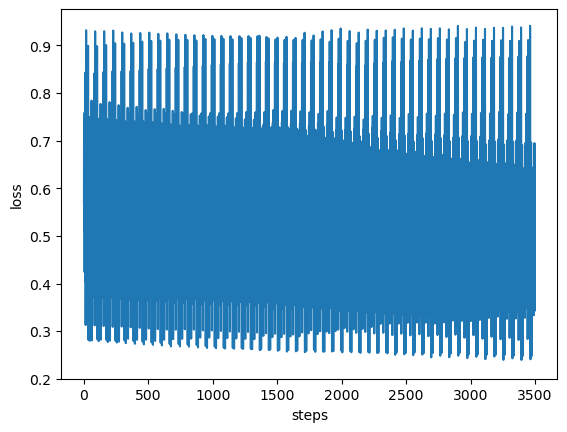

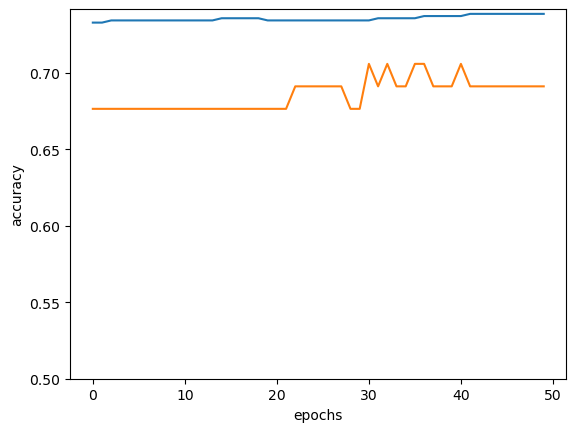

In [33]:
# visualize metrics
# Plot the loss metrics, set the y-axis to start from 0
plt.plot(train_loss)
plt.xlabel("steps")
plt.ylabel("loss")
plt.ylim(0.2)
plt.show()
 
# plot the accuracy metrics
avg_train_acc = []
for i in range(n_epochs):
    start = i * batch_size
    average = sum(train_acc[start:start+batches_per_epoch]) / batches_per_epoch
    avg_train_acc.append(average)

plt.plot(avg_train_acc, label="train")
plt.plot(test_acc, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.5)
plt.show()

## 5 Evaluate the Model
- Goal:
    - choose a model configuration and training configuration that achieve the lowest loss and the highest accuracy posiible for a given dataset
- Over- and Underfitting:
    - **Overfitting**: model fits perfectly on the training set and therfore performs worse on the test set
        - implement early stopping
    - **Underfitting**: model is to simple to capture the complex associations

In [36]:
# comptue accuracy on test set
with torch.no_grad():
    y_pred = model(Xtest)
accuracy = (y_pred.round() == ytest).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.6911764740943909


## 6 Make Predictions
- call the model as if is a function


In [37]:
predictions = model(Xtest)
print(predictions[:10])
# use round to assign output to class 0 and 1
pred_round = predictions.round()
print(pred_round[:10])

tensor([[0.2667],
        [0.3682],
        [0.3763],
        [0.4407],
        [0.1184],
        [0.1004],
        [0.1048],
        [0.3442],
        [0.6845],
        [0.2486]], grad_fn=<SliceBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], grad_fn=<SliceBackward0>)


## Resources
- https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
- https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/
- https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0